In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def cross(vector1, vector2):
    """
    3D cross product between two vectors, potentially batched
    """
    vector1_x, vector1_y, vector1_z = tf.unstack(vector1, axis=-1)
    vector2_x, vector2_y, vector2_z = tf.unstack(vector2, axis=-1)
    n_x = vector1_y * vector2_z - vector1_z * vector2_y
    n_y = vector1_z * vector2_x - vector1_x * vector2_z
    n_z = vector1_x * vector2_y - vector1_y * vector2_x
    return tf.stack((n_x, n_y, n_z), axis=-1)

def trace_ray(camera_position, camera_direction, camera_rotation, side, side_count=8):
    """
    Output the positions to be sampled, as a 3d map
    works on batches 
    
    camera_position: 3-d vector
    camera_direction: 3-d unite vector
    camera_rotaion: float, radian, zero is default
    side: float, radian, what angle the camera is able to view
    """    
    #Finding camera orientation before rotation
    y_dir = tf.constant(tf.constant([0,1,0], dtype=tf.float32), dtype=tf.float32) #(*,3)
    camera_x = cross(y_dir, camera_direction) #(*,3)
    camera_y = cross(camera_direction, camera_x) #(*,3)
    
    #Applying camera rotation
    rot_cos = tf.cos(camera_rotation[:,tf.newaxis]) # (*,)
    rot_sin = tf.sin(camera_rotation[:,tf.newaxis]) # (*,)
    camera_x, camera_y = (rot_cos*camera_x + rot_sin*camera_y, 
                          -rot_sin*camera_x + rot_cos*camera_y) # (*,3)
        
    dist_to_zero = tf.norm(camera_position, axis=-1) #(*,)
    half_side = side*dist_to_zero/2 # (*,)
    linspace = tf.linspace(-half_side,half_side, side_count, axis=1) #(*,side_count)
    #Relative to the center of the grid
    grid_x = camera_x[:,tf.newaxis,tf.newaxis,:] * linspace[:,tf.newaxis,:,tf.newaxis] #(*,1,side_count,3)
    grid_y = - camera_y[:,tf.newaxis,tf.newaxis,:] * linspace[:,:,tf.newaxis,tf.newaxis] #(*,side_count,1,3)
    
    grid_xy = grid_x + grid_y # (*,side_count,side_count,3)
    #Relative to camera 
    grid_xy = grid_xy + (dist_to_zero[:,tf.newaxis]*camera_direction)[:,tf.newaxis,tf.newaxis,:]
    
    grid_xyz = grid_xy[:,tf.newaxis,:,:,:] * (1 + linspace/dist_to_zero[:,np.newaxis])[:,:,tf.newaxis,tf.newaxis,tf.newaxis] # (*,side_count,side_count,side_count,3)    
    return grid_xyz + camera_position[:,tf.newaxis,tf.newaxis,tf.newaxis,:]


def to_feature_map(feature_3D):
    """
    Sums the rays along axis 1, output a feature map 
    """
    coefficients = tf.reduce_sum(tf.abs(feature_3D),axis=4, keepdims=True) #(*,side_count,side_count,side_count,1)
    coefficients = 1/(1 + tf.math.cumsum(coefficients, axis=1)) #(*,side_count,side_count,side_count,1)
    feature_map = tf.reduce_sum(coefficients*feature_3D, axis=1) #(*,side_count,side_count,1)
    return feature_map
    


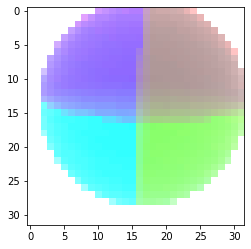

In [47]:
class CameraStd(keras.layers.Layer):
    def __init__(self):
        super(CameraStd, self).__init__()
        """
        Learnable parameters for the standard deviations of the random gaussians noise
        """
        self.theta_std = self.add_weight(name="theta_std", initializer=tf.constant_initializer(0.2))
        self.phi_std = self.add_weight(name="phi_std", initializer=tf.constant_initializer(1.))
        self.rotation_std = self.add_weight(name="rotation_std", initializer=tf.constant_initializer(0.1))
        self.center_std = self.add_weight(name="center_std", initializer=tf.constant_initializer(0.1))
        self.side_std = self.add_weight(name="side_std", initializer=tf.constant_initializer(0.1))
        self.distance_std = self.add_weight(name="distance_std", initializer=tf.constant_initializer(4))
        self.base_distance = self.add_weight(name="base_distance", initializer=tf.constant_initializer(15))
    
        self.dir_x = tf.constant([1,0,0], dtype=tf.float32)
        self.dir_y = tf.constant([0,1,0], dtype=tf.float32)
        self.dir_z = tf.constant([0,0,1], dtype=tf.float32)
    
    def call(self, inputs):
        """
        Inputs, all random values zero centered std 1:
        camera_angles : (*,3)
        center : (*,3)
        distance : (*)
        side : (*)
        """
        camera_angles, center, distance, side = inputs
        
        #Rotation
        theta = camera_angles[:,0] * self.theta_std # (*,)
        phi = camera_angles[:,1] * self.phi_std # (*,)
        camera_rotation = camera_angles[:,2] * self.rotation_std # (*,)
        #print(f"theta: {theta.numpy()}")
        #print(f"phi: {phi.numpy()}")
        #print(f"camera_rotation: {camera_rotation.numpy()}")
        
        #Camera position
        distance = self.base_distance+self.distance_std*distance
        #print(f"distance: {distance.numpy()}")
        dir_camera_phi = tf.cos(phi[:,tf.newaxis]) * self.dir_z + tf.sin(phi[:,tf.newaxis]) * self.dir_x 
        dir_camera = tf.cos(theta[:,tf.newaxis]) * dir_camera_phi + tf.sin(theta[:,tf.newaxis]) * self.dir_y # (*, 3)
        camera_position = dir_camera * distance[:,tf.newaxis] # (*, 3)
            
        #Camera direction
        center = center * self.center_std # (*, 3)
        camera_direction, _ = tf.linalg.normalize(center - camera_position, axis=1)  # (*, 3)
        
        #Side
        side = (self.side_std*side + 1) / distance # (*,)
            
        return camera_position, camera_direction, camera_rotation, side
    
class RayTracer(keras.layers.Layer):
    def __init__(self, side_count=8):
        """
        Sample coordinate accross rays.
        output is of shape (*,side_count,side_count,side_count,3)
        """
        super(RayTracer, self).__init__()
        
        self.side_count = side_count

    def call(self, inputs):
        camera_position, camera_direction, camera_rotation, side = inputs 
        return trace_ray(camera_position, camera_direction, camera_rotation, side, side_count=self.side_count)
    
def get_random_noise(batch_size=8):
    random_noise = np.random.normal(size=(batch_size, 8)).astype(dtype=np.float32)
    return random_noise[:,:3], random_noise[:,3:6], random_noise[:,6], random_noise[:,7]
    
def get_zero_noise(batch_size=8):
    random_noise = np.zeros((batch_size, 8)).astype(dtype=np.float32)
    return random_noise[:,:3], random_noise[:,3:6], random_noise[:,6], random_noise[:,7]

cam_std = CameraStd()
rt = RayTracer(side_count = 32)
inputs = cam_std(get_random_noise(batch_size=16))
rays = rt(inputs)
colors = sphere(rays)
colors = to_feature_map(colors)
colors = colors / tf.reduce_max(tf.abs(colors))
plt.imshow(1-colors[0])
plt.show()

In [29]:
64**3

262144

## Test

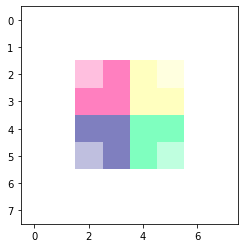

In [88]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
im=plt.imshow(np.ones((8,8,3)))

# initialization function: plot the background of each frame
def init():
    return (im,)

# animation function. This is called sequentially
def animate(i):
    camera_position = np.array([[0,0,10]], dtype=np.float32)
    camera_direction = np.array([[0,0,-1]], dtype=np.float32)
    camera_rotation = np.array([i/20], dtype=np.float32)
    side = np.array([0.15], dtype=np.float32)
    rays = trace_ray(camera_position, camera_direction, camera_rotation, side, side_count=8)
    colors = sphere(rays)
    colors = tf.reduce_sum(colors,axis=1) / 8
    im.set_data(1-colors[0])
    return (im,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

HTML(anim.to_html5_video())

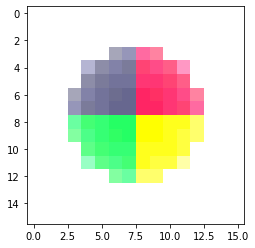

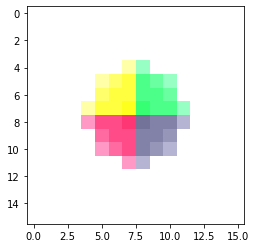

In [9]:
def sphere(pos):
    r1 = tf.cast((pos[...,0] > 0), tf.float32)
    r2 = tf.cast((pos[...,1] > 0), tf.float32)
    r3 = tf.cast((pos[...,2] > 0), tf.float32)
    res = tf.stack([r1,r2,r3], axis=-1)
    inside = tf.cast(tf.norm(pos, axis=-1) < 0.5, tf.float32)
    res = res*inside[...,tf.newaxis]
    return res
    
camera_position = np.array([[0,0,10],[0,0,10]], dtype=np.float32)
camera_direction = np.array([[0,0,-1],[0,0,-1]], dtype=np.float32)
camera_rotation = np.array([0,3.1415], dtype=np.float32)
side = np.array([0.15,0.2], dtype=np.float32)

rays = trace_ray(camera_position, camera_direction, camera_rotation, side, side_count=16)
colors = sphere(rays)
colors = to_feature_map(colors)
colors = colors / tf.reduce_max(tf.abs(colors))
plt.imshow(1-colors[0])
plt.show()
plt.imshow(1-colors[1])
plt.show()